In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.domain import Domain
from src.interpolation import SplineInter
from src.transformations import Affine2d
from src.plotting import view_image_2d, plot_grid_2d
from src.super_resolution_tools import *
from src.transformations import Affine2d
from src.LinearOperator import LinearOperator
from src.lanczos import lanczos_tridiag
from src.utils import * 
from src.optimization import *
import torch.func as func
from src.distance import SSDDistance
import time

torch.set_default_dtype(torch.float64)

In [2]:
def show_reference_and_templates(R, T):

    # Determine the layout for the subplots
    num_images = 1 + T.shape[0]  # Total number of images (reference + targets)
    cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
    rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

    # Create the figure with subplots
    _, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    # Flatten the ax array for easier indexing
    ax = ax.flatten()

    # Display the reference image
    ax[0].imshow(R.detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[0].set_title('Reference')
    ax[0].axis('off')  # Optional: hide axes for cleaner visualization

    # Display the target images
    for k in range(T.shape[0]):
        ax[k + 1].imshow(T[k].detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
        ax[k + 1].set_title(f'T_{k}')
        ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

    # Turn off any unused subplots
    for i in range(1 + T.shape[0], len(ax)):
        ax[i].axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
    plt.show()

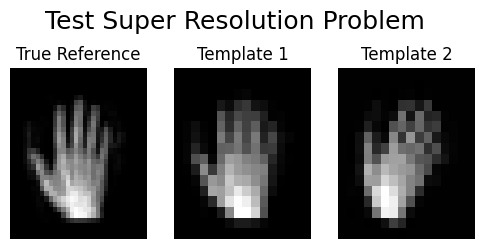

In [3]:
m = 32
factor = 2
theta = 0
n_images = 2

domain_R = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m, m)))
domain_R.m.detach()
domain_T = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m//factor, m//factor)))
xc = domain_R.getCellCenteredGrid().view(-1, 2).to(torch.float64)
times = torch.linspace(0, 15, n_images)

R = Image.open('../data/hands-R.jpg')
R = R.resize((m, m))
R = torch.fliplr(torch.tensor(R.getdata(), dtype=torch.float64).view(m,m).transpose(0,1))
Rimg = SplineInter(R, domain_R ,regularizer='moments',theta=theta).to(torch.float64)

def randomAffines(reference, n):
    affines = [getRandomAffine(rotation_range=(0,45),seed=_+2) for _ in range(n-1)]
    templates = [down_sample(reference(xc).reshape(m, m), factor)]
    for aff in affines:
        affine = Affine2d()
        affine.A = torch.nn.Parameter(aff[0].to(torch.float64))
        affine.b = torch.nn.Parameter(aff[1].to(torch.float64))
        templates.append(down_sample(reference(affine(xc)).reshape(m, m), factor))
    return torch.stack(templates)

T = randomAffines(Rimg, len(times))

#show_reference_and_templates(R, T)

fig, ax = plt.subplots(1, n_images + 1, figsize = (6,2.5))

[a.axis('off') for a in ax]

plt.sca(ax[0])
view_image_2d(R, domain_R)
plt.title("True Reference")

for i in range(n_images):
    plt.sca(ax[i+1])
    view_image_2d(T[i].detach(), domain_T)
    plt.title("Template {}".format(i+1))

plt.suptitle("Test Super Resolution Problem", fontsize=18, y=1.07)

plt.savefig('../results/figs/SR_test.pdf', bbox_inches='tight')

plt.show()

In [4]:
def L_forward(f):
    reference = f.reshape(*domain_R.m)
    diff_0 = torch.diff(reference, dim = 0) / domain_R.h[0]
    diff_1 = torch.diff(reference, dim = 1) / domain_R.h[1]
    return torch.hstack([diff_0.flatten(), diff_1.flatten()])

L = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=L_forward, dtype = torch.float64)

def K_forward(f):
    reference = f.reshape(*domain_R.m)
    downsampled = down_sample(reference, factor).flatten()
    return downsampled.flatten() 

K = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=K_forward, dtype = torch.float64)
# f0_interp = K.T @ T[0].flatten().detach()
Timg = SplineInter(T[0].detach(),domain_T, regularizer='moments', theta=1e-2)
f0_interp = Timg(domain_R.getCellCenteredGrid()).flatten()

d = T.flatten()
b = torch.hstack([d * torch.sqrt(torch.prod(domain_T.h)), torch.zeros_like(L @ f0_interp)])

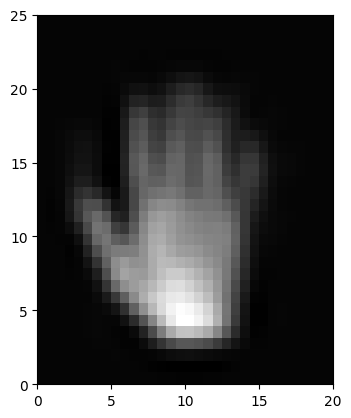

In [5]:
view_image_2d(f0_interp, domain_R)

In [6]:
xc_2d = domain_R.getCellCenteredGrid()
xc = xc_2d.reshape(torch.prod(domain_R.m).item(),2).detach()

ys = [Affine2d() for _ in range(n_images)]
for y in ys:
    for param in y.parameters():
        param.to(torch.float64)
        param.requires_grad_(True)

lam = 1e-2

wps = [{k: v for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec0 = torch.stack(flat_params_list).flatten().unsqueeze(1)


In [7]:
f0_grad = None
f0_nograd = None
def conjugate_gradient(A, b, x0, max_iter=500, tol=1e-3):
    x = x0.clone()
    r = b - A(x)
    p = r.clone()
    rsold = r.dot(r)
        
    for i in range(max_iter):
        Ap = A(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print("early iters",i)
            # print(f"tol reached {i}")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    # print(f"residual norm: {torch.sqrt(rsnew)}")
    # print("iters", i)
    return x
    

def conjugate_gradient_nograd(A, b, x0, max_iter=500, tol=1e-3):
    with torch.no_grad():
        x = x0.clone()
        r = b - A(x)
        p = r.clone()
        rsold = r.dot(r)
        for i in range(max_iter):
            Ap = A(p)
            alpha = rsold / p.dot(Ap)
            x = x + alpha * p 
            x = x.detach()
            r = r - alpha * Ap  
            rsnew = r.dot(r)
            if torch.sqrt(rsnew) < tol:
                # print("early iters",i)
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew
        # print(f"residual norm: {torch.sqrt(rsnew)}")
        # print("iters", i)
        return x

def Forward_single(wp, y, f_inter):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, xc)
    d_pred = K(f_inter(yc))
    return d_pred

def res_fn(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R).to(torch.float64)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_interp, max_iter=cg_iter)
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R).to(torch.float64)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def res_fn_nodiff(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= cg_iter)
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def res_fn_lastdiff(wp_vec, cg_iter, somegrad_percent):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0_early = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, int(cg_iter * (1 - somegrad_percent)))
    f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_early, int(cg_iter * somegrad_percent))
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def res_fn_firstdiff(wp_vec, cg_iter, somegrad_percent):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0_early = conjugate_gradient(A.T ^ A, A.T @ b, f0_interp, int(cg_iter * somegrad_percent))
    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_early, int(cg_iter * (1 - somegrad_percent)))
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def Jac_fn(wp_vec, cg_iter):
    return func.jacfwd(res_fn)(wp_vec, cg_iter).detach().squeeze()

def Jac_fn_nodiff(wp_vec, cg_iter):
    return func.jacfwd(res_fn_nodiff)(wp_vec, cg_iter).detach().squeeze()

def Jac_fn_lastdiff(wp_vec, cg_iter, somegrad_percent):
    return func.jacfwd(res_fn_lastdiff)(wp_vec, cg_iter, somegrad_percent).detach().squeeze()

def Jac_fn_firstdiff(wp_vec, cg_iter, somegrad_percent):
    return func.jacfwd(res_fn_firstdiff)(wp_vec, cg_iter, somegrad_percent).detach().squeeze()




/tmp/ipykernel_48988/2815001452.py:61: OptimizeWarning: Unknown solver options: gtol
  results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',


1 - Current Loss: 1.0695670944e+06, Norm of Gradient: 1.3270221177e+05
2 - Current Loss: 1.0474810129e+06, Norm of Gradient: 1.0018404314e+05
3 - Current Loss: 1.0423465245e+06, Norm of Gradient: 2.4040955965e+04
4 - Current Loss: 1.0328145177e+06, Norm of Gradient: 2.0813195127e+04
5 - Current Loss: 1.0186404704e+06, Norm of Gradient: 1.6508456510e+04
6 - Current Loss: 1.0178952497e+06, Norm of Gradient: 5.8197547322e+03
7 - Current Loss: 1.0165903640e+06, Norm of Gradient: 4.1734505969e+03
8 - Current Loss: 1.0151319569e+06, Norm of Gradient: 2.1072314231e+03
9 - Current Loss: 1.0151311575e+06, Norm of Gradient: 8.1650713445e+02
10 - Current Loss: 1.0150093365e+06, Norm of Gradient: 7.0293604218e+02
11 - Current Loss: 1.0147853766e+06, Norm of Gradient: 3.1003915516e+03
12 - Current Loss: 1.0147550543e+06, Norm of Gradient: 1.0182305004e+03
13 - Current Loss: 1.0146990303e+06, Norm of Gradient: 1.1958008645e+03
14 - Current Loss: 1.0146613207e+06, Norm of Gradient: 2.3259678797e+03
1

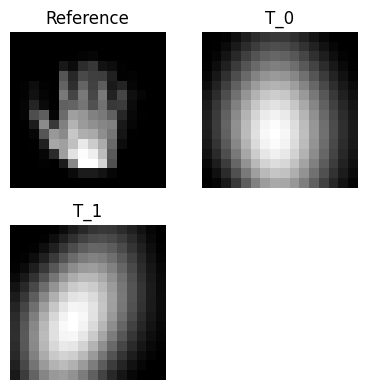

1 - Current Loss: 4.3703032694e+05, Norm of Gradient: 2.3498727382e+05
2 - Current Loss: 4.1289875803e+05, Norm of Gradient: 6.8065165231e+04
3 - Current Loss: 4.0766154786e+05, Norm of Gradient: 2.3468270366e+04
4 - Current Loss: 3.9887557390e+05, Norm of Gradient: 1.4858508636e+04
5 - Current Loss: 3.9309830559e+05, Norm of Gradient: 1.6199200778e+04
6 - Current Loss: 3.9308070526e+05, Norm of Gradient: 5.6845779913e+03
7 - Current Loss: 3.9029890246e+05, Norm of Gradient: 1.1753776173e+04
8 - Current Loss: 3.9023413288e+05, Norm of Gradient: 3.7721289434e+03
9 - Current Loss: 3.8961562451e+05, Norm of Gradient: 3.3419757610e+03
10 - Current Loss: 3.8861752023e+05, Norm of Gradient: 5.7882722421e+03
11 - Current Loss: 3.8860168219e+05, Norm of Gradient: 2.2316321680e+03
12 - Current Loss: 3.8845649652e+05, Norm of Gradient: 1.8191194678e+03
13 - Current Loss: 3.8824711486e+05, Norm of Gradient: 1.6933862522e+03
14 - Current Loss: 3.8824587004e+05, Norm of Gradient: 4.8521218728e+02
1

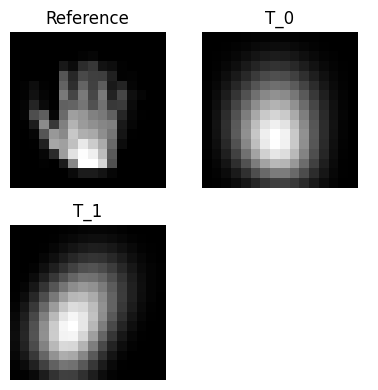

1 - Current Loss: 2.6736640781e+05, Norm of Gradient: 3.1419645009e+05
2 - Current Loss: 2.3243565941e+05, Norm of Gradient: 1.2278685380e+05
3 - Current Loss: 2.2431042485e+05, Norm of Gradient: 8.4724943484e+04
4 - Current Loss: 2.2099016168e+05, Norm of Gradient: 3.1994802341e+04
5 - Current Loss: 1.9699239944e+05, Norm of Gradient: 5.2334315997e+04
6 - Current Loss: 1.9688245392e+05, Norm of Gradient: 1.8704290090e+04
7 - Current Loss: 1.8214534759e+05, Norm of Gradient: 2.6480154319e+04
8 - Current Loss: 1.8195362694e+05, Norm of Gradient: 1.0285734295e+04
9 - Current Loss: 1.8033839936e+05, Norm of Gradient: 7.2837331790e+03
10 - Current Loss: 1.7762339158e+05, Norm of Gradient: 5.4616327922e+03
11 - Current Loss: 1.7654122517e+05, Norm of Gradient: 4.7661423186e+03
12 - Current Loss: 1.7606864938e+05, Norm of Gradient: 2.5113009429e+03
13 - Current Loss: 1.7573058816e+05, Norm of Gradient: 1.5131488938e+03
14 - Current Loss: 1.7573009675e+05, Norm of Gradient: 1.2797878684e+02
1

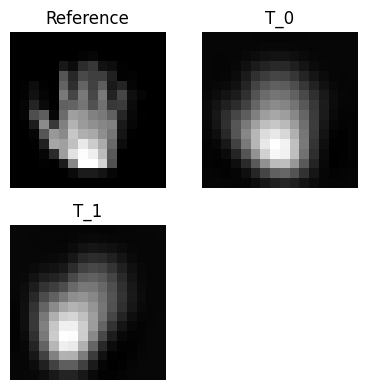

1 - Current Loss: 2.2572010634e+05, Norm of Gradient: 3.6441104329e+05
2 - Current Loss: 1.8118369573e+05, Norm of Gradient: 3.1952328790e+05
3 - Current Loss: 1.4842429925e+05, Norm of Gradient: 7.2285514684e+04
4 - Current Loss: 1.0588131600e+05, Norm of Gradient: 9.9902752494e+04
5 - Current Loss: 1.0554962569e+05, Norm of Gradient: 5.4680250038e+04
6 - Current Loss: 1.0502943165e+05, Norm of Gradient: 3.0822685773e+04
7 - Current Loss: 8.4530564865e+04, Norm of Gradient: 3.7074059053e+04
8 - Current Loss: 7.3160656523e+04, Norm of Gradient: 3.1405199239e+05
9 - Current Loss: 7.1680281455e+04, Norm of Gradient: 3.7329460745e+04
10 - Current Loss: 7.1457544521e+04, Norm of Gradient: 1.3764871621e+04
11 - Current Loss: 6.9639912867e+04, Norm of Gradient: 9.4594376840e+03
12 - Current Loss: 6.8040791287e+04, Norm of Gradient: 8.3625234119e+03
13 - Current Loss: 6.7589284593e+04, Norm of Gradient: 2.7404758601e+03
14 - Current Loss: 6.7463676941e+04, Norm of Gradient: 1.0552085795e+03
1

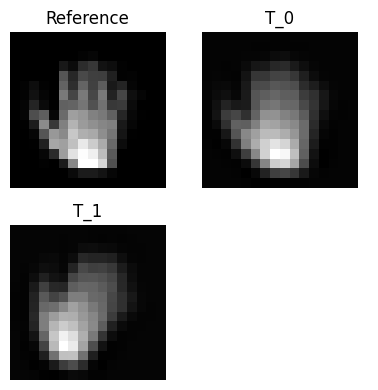

1 - Current Loss: 2.3289968533e+05, Norm of Gradient: 3.3589759357e+05
2 - Current Loss: 1.7985560388e+05, Norm of Gradient: 1.4246147143e+06
3 - Current Loss: 1.6268390815e+05, Norm of Gradient: 4.5088232305e+05
4 - Current Loss: 1.4192382281e+05, Norm of Gradient: 1.4805994867e+05
5 - Current Loss: 1.3191702690e+05, Norm of Gradient: 2.5424389777e+05
6 - Current Loss: 1.2088132569e+05, Norm of Gradient: 1.0777866387e+05
7 - Current Loss: 1.0093277691e+05, Norm of Gradient: 1.2259411623e+05
8 - Current Loss: 1.0062435184e+05, Norm of Gradient: 4.8073812181e+04
9 - Current Loss: 8.9231168462e+04, Norm of Gradient: 3.4134109726e+04
10 - Current Loss: 7.3551195585e+04, Norm of Gradient: 1.7635698148e+05
11 - Current Loss: 7.2148792840e+04, Norm of Gradient: 3.1283808823e+04
12 - Current Loss: 7.0582294014e+04, Norm of Gradient: 5.7514931387e+04
13 - Current Loss: 6.8156019182e+04, Norm of Gradient: 7.1484320521e+04
14 - Current Loss: 6.7557670296e+04, Norm of Gradient: 4.6489859835e+04
1

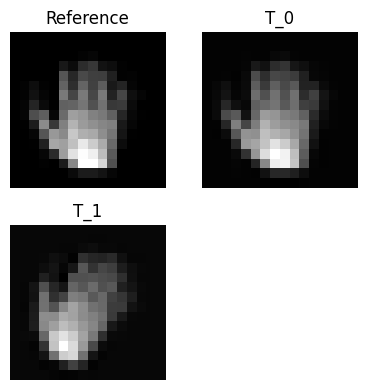

1 - Current Loss: 2.8972513967e+05, Norm of Gradient: 1.1407240346e+06
2 - Current Loss: 1.6032545182e+05, Norm of Gradient: 5.5880960379e+05
3 - Current Loss: 1.5607872753e+05, Norm of Gradient: 3.9862814417e+05
4 - Current Loss: 1.5359577569e+05, Norm of Gradient: 2.6866034682e+05
5 - Current Loss: 1.4956504327e+05, Norm of Gradient: 1.6216018065e+05
6 - Current Loss: 1.4434054219e+05, Norm of Gradient: 1.2858676134e+05
7 - Current Loss: 1.4190577545e+05, Norm of Gradient: 1.4927201801e+05
8 - Current Loss: 1.2882590848e+05, Norm of Gradient: 2.0168108695e+05
9 - Current Loss: 1.2032187434e+05, Norm of Gradient: 5.9288613127e+04
10 - Current Loss: 1.0462447140e+05, Norm of Gradient: 7.3738744103e+04
11 - Current Loss: 1.0451983658e+05, Norm of Gradient: 3.6347481904e+04
12 - Current Loss: 8.9802283520e+04, Norm of Gradient: 2.4487721736e+04
13 - Current Loss: 7.6147323317e+04, Norm of Gradient: 2.5067287925e+05
14 - Current Loss: 7.1713054236e+04, Norm of Gradient: 1.1437790204e+05
1

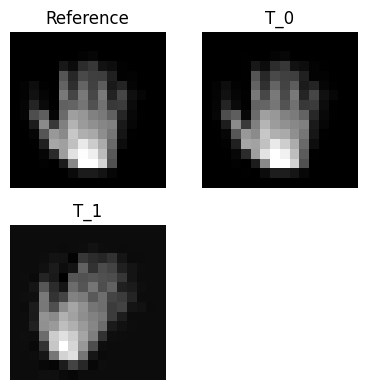

In [8]:
# preregistration

from scipy.optimize import minimize

def single_img_trafo(wp,y):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, domain_T.getCellCenteredGrid())
    # print(Timg(yc).shape)
    return Timg(yc).flatten()

def lossfn(wp_vec):
    pred_d = torch.hstack([single_img_trafo(wp_vec.reshape(-1,6)[j], ys[j]) for j in range(n_images)])
    return torch.norm(pred_d - d)**2


def scipy_loss(wc):
    global last_loss
    wc_tensor = numpy_to_tensor(wc)
    loss = lossfn(wc_tensor)
    last_loss = loss.item()
    return last_loss

def scipy_grad(wc):
    global last_grad
    wc = numpy_to_tensor(wc)
    grad = torch.func.grad(lossfn, argnums=0)(wc).detach()
    last_grad = tensor_to_numpy(grad)
    return last_grad

def scipy_hessian(wc):
    wc = numpy_to_tensor(wc)
    hessian = torch.func.hessian(lossfn, argnums=0)(wc).detach()
    hessian = .5 * (hessian + hessian.T)
    return tensor_to_numpy(hessian)

def callback(xk):
    norm_grad = np.linalg.norm(last_grad)
    grad_norms.append(norm_grad)
    global iteration_num
    iteration_num+=1
    print(f'{iteration_num} - Current Loss: {last_loss:.10e}, Norm of Gradient: {norm_grad:.10e}')

# multi-scale 

thetas = torch.logspace(2, -3, 6)

for theta in thetas:

    theta_np = tensor_to_numpy(theta)

    last_loss = None
    last_grad = None
    iteration_num = 0

    grad_norms = []

    Timg = SplineInter(T[0].detach(), domain_T,regularizer='moments',theta=theta)
    Rimgs = [SplineInter(T[i], domain_T, regularizer='moments', theta=theta) for i in range(n_images)]
    Rcs = torch.stack([Rimgs[i](domain_T.getCellCenteredGrid()) for i in range(len(Rimgs))])

    results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',
               jac=scipy_grad, hess=scipy_hessian,
               options={'gtol': 1e-2, 'maxiter':50}, callback=callback)
    
    template_predictions = torch.stack([single_img_trafo(numpy_to_tensor(results.x).reshape(-1,6)[j], ys[j]).reshape(*domain_T.m) for j in range(n_images)])
    show_reference_and_templates(T[0], template_predictions)


# Using Last Iters of CG:

In [45]:
maxcg_iters = 200 # verified that all iterations reach max_iters before stopping
proportions = [0.5,  0.7,  0.9, 1]

f0_grads = []
loss_grads = []
grad_grads = []

for prop in proportions:
    wp_list,_,losses,grads = lsq_lma(numpy_to_tensor(results.x).flatten(), 
                                     res_fn_lastdiff, 
                                     Jac_fn_lastdiff, 
                                     args=[maxcg_iters, prop], 
                                     gtol=1e-5, max_iter=20, 
                                     verbose=False, 
                                     return_loss_and_grad=True)
    wp_vec = wp_list[-1]
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])
        regularizer = lam * L(f)
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)
    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= 5000, tol=1e-12)
    f0_grad_reshaped = f0.reshape(*domain_R.m)

    f0_grads.append(f0_grad_reshaped.clone().detach())
    loss_grads.append(losses)
    grad_grads.append(grads)

/tmp/ipykernel_48988/3372658057.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')
/tmp/ipykernel_48988/3372658057.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')


<function matplotlib.pyplot.show(close=None, block=None)>

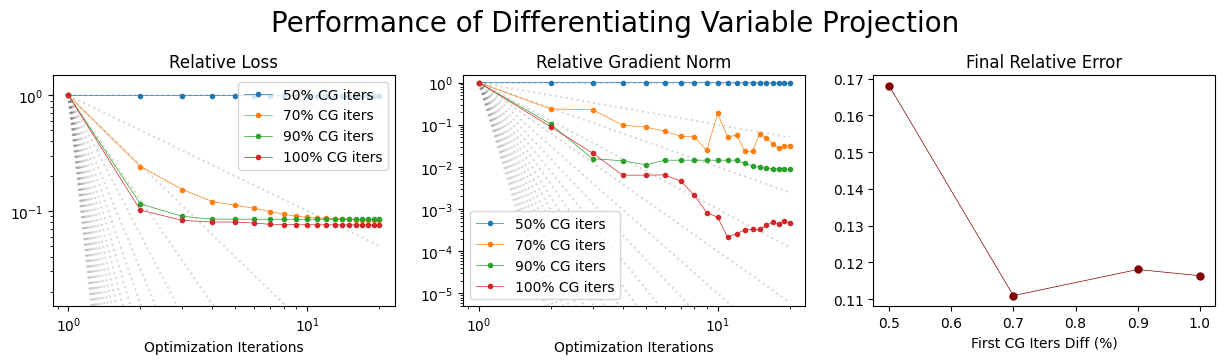

In [46]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

plt.sca(ax[0])
for i in range(20):
    plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(proportions)):
    plt.loglog(np.arange(20) + 1, np.array(loss_grads[i])/loss_grads[i][0], label="{}% CG iters".format(int(proportions[i]*100)), linewidth=0.5, marker = '.')
plt.legend(loc = 'upper right')
plt.ylim(1.5e-2,1.5)
plt.title('Relative Loss')
plt.xlabel('Optimization Iterations')

plt.sca(ax[1])
for i in range(20):
    plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(proportions)):
    plt.loglog(np.arange(20) + 1, np.array(grad_grads[i])/grad_grads[i][0], label="{}% CG iters".format(int(proportions[i]*100)), linewidth=0.5, marker = '.')
plt.legend()
plt.ylim(5e-6,1.5)
plt.title('Relative Gradient Norm')
plt.xlabel('Optimization Iterations')

plt.sca(ax[2])
plt.plot(proportions, np.array([torch.norm(f - R) for f in f0_grads])/torch.norm(R), linewidth=0.5, marker = '.', markersize=10, color='maroon')
plt.title('Final Relative Error')
plt.xlabel(f'First CG Iters Diff (%)')

plt.suptitle('Performance of Differentiating Variable Projection', y = 1.1, size=20)
plt.savefig('../results/figs/diff_CG_Performance.pdf', bbox_inches='tight')
plt.show

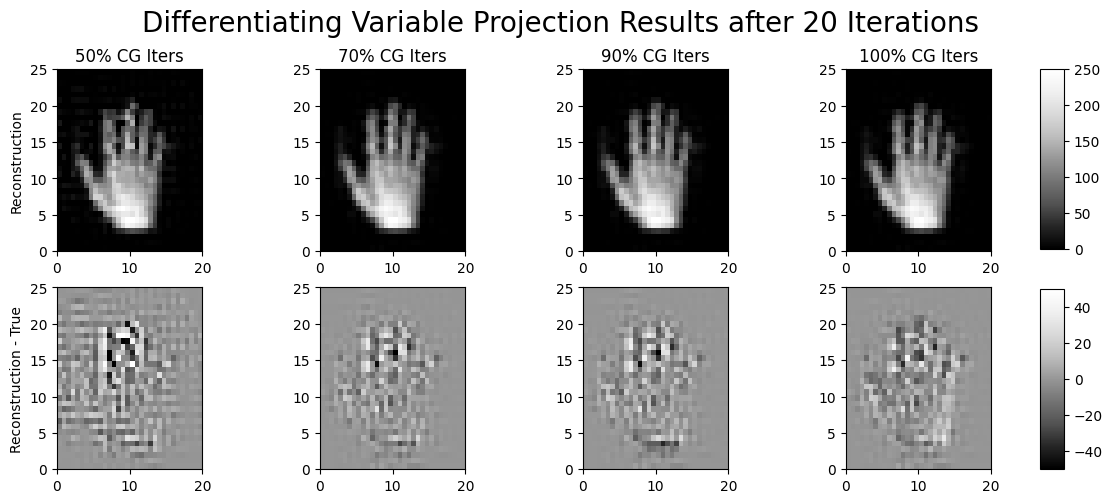

In [47]:
fig, ax = plt.subplots(2, len(proportions), figsize=(12,4))

for i in range(len(proportions)):
    #ax[0,i].axis('off')
    #ax[1,i].axis('off')

    plt.sca(ax[0,i])
    im_0 = view_image_2d(f0_grads[i],domain_R, kwargs={'clim':(0,250), 'cmap':'Greys_r'})
    plt.title("{}% CG Iters".format(int(proportions[i]*100)))

    plt.sca(ax[1,i])
    im_1 = view_image_2d(f0_grads[i] - R,domain_R, kwargs={'clim':(-50,50), 'cmap':'Greys_r'})

ax[0,0].set_ylabel("Reconstruction")
ax[1,0].set_ylabel("Reconstruction - True")

fig.subplots_adjust(0,0,.84,1)

# Create colorbar axes
cbar_ax1 = fig.add_axes([0.85, 0.55, 0.02, 0.45])  # x, y, width, height
cbar_ax2 = fig.add_axes([0.85, 0.0, 0.02, 0.45])

# Create colorbars in the new axes
cbar1 = plt.colorbar(im_0, cax=cbar_ax1)
cbar2 = plt.colorbar(im_1, cax=cbar_ax2)

plt.suptitle('Differentiating Variable Projection Results after 20 Iterations', y = 1.15, x=.45, size=20)

plt.savefig('../results/figs/diff_reconstructions.pdf', bbox_inches='tight')

plt.show()


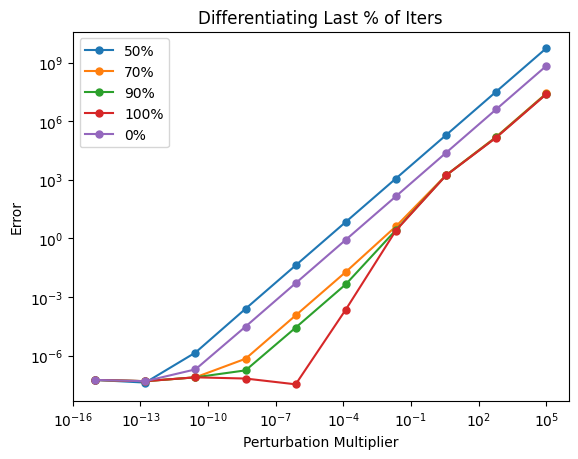

In [43]:
maxcg_iters = 200 # verified that all iterations reach max_iters before stopping
proportions = [0.5,  0.7,  0.9, 1]


H = torch.logspace(5,-15,10)
# Loop through each subplot and plot

fifty = []
seventy = []
ninety = []
all_grad = []
no_grad = []
v = Jac_fn_lastdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 1).T @ res_fn_nodiff(numpy_to_tensor(results.x).flatten(), maxcg_iters) 
v /= torch.norm(v)
f_x = res_fn_nodiff(numpy_to_tensor(results.x).flatten(), maxcg_iters)
Jacv_fifty = Jac_fn_lastdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0.5) @ v
Jacv_seventy = Jac_fn_lastdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0.7) @ v
Jacv_ninety = Jac_fn_lastdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0.9) @ v
Jacv_all = Jac_fn_lastdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 1) @ v
Jacv_no = Jac_fn_lastdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0) @ v

for h in H:
    fifty.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_fifty).detach())
    seventy.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_seventy).detach())
    ninety.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_ninety).detach())
    all_grad.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_all).detach())
    no_grad.append(torch.norm(res_fn(numpy_to_tensor(results.x) + h * v, maxcg_iters) - f_x - h * Jacv_no).detach())
plt.plot(H, fifty, marker='.', markersize=10, label = '50%')
plt.plot(H, seventy, marker='.', markersize=10, label = '70%')
plt.plot(H, ninety, marker='.', markersize=10, label = '90%')
plt.plot(H, all_grad, marker='.', markersize=10, label = '100%')
plt.plot(H, no_grad, marker='.', markersize=10, label = '0%')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Perturbation Multiplier")
plt.ylabel("Error")
plt.title(f"Differentiating Last % of Iters")

plt.savefig('../results/figs/diff_CG_iters_deriv.pdf')

plt.show()

# Using First Iters of CG:

In [37]:
maxcg_iters = 200 # verified that all iterations reach max_iters before stopping
proportions = [0.5,  0.7,  0.9, 1]

f0_grads = []
loss_grads = []
grad_grads = []

for prop in proportions:
    wp_list,_,losses,grads = lsq_lma(numpy_to_tensor(results.x).flatten(), 
                                     res_fn_firstdiff, 
                                     Jac_fn_firstdiff, 
                                     args=[maxcg_iters, prop], 
                                     gtol=1e-5, max_iter=20, 
                                     verbose=False, 
                                     return_loss_and_grad=True)
    wp_vec = wp_list[-1]
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])
        regularizer = lam * L(f)
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)
    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= 5000, tol=1e-12)
    f0_grad_reshaped = f0.reshape(*domain_R.m)

    f0_grads.append(f0_grad_reshaped.clone().detach())
    loss_grads.append(losses)
    grad_grads.append(grads)

/tmp/ipykernel_48988/364908835.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')
/tmp/ipykernel_48988/364908835.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')


Text(0.5, 1.1, 'Performance of Differentiating Variable Projection')

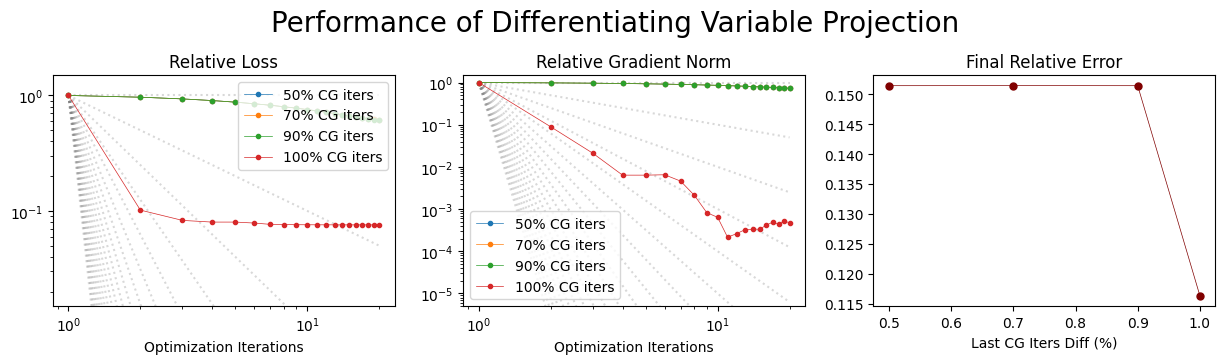

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

plt.sca(ax[0])
for i in range(20):
    plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(proportions)):
    plt.loglog(np.arange(20) + 1, np.array(loss_grads[i])/loss_grads[i][0], label="{}% CG iters".format(int(proportions[i]*100)), linewidth=0.5, marker = '.')
plt.legend(loc = 'upper right')
plt.ylim(1.5e-2,1.5)
plt.title('Relative Loss')
plt.xlabel('Optimization Iterations')

plt.sca(ax[1])
for i in range(20):
    plt.loglog(np.arange(20) + 1, 1/(np.arange(20) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(proportions)):
    plt.loglog(np.arange(20) + 1, np.array(grad_grads[i])/grad_grads[i][0], label="{}% CG iters".format(int(proportions[i]*100)), linewidth=0.5, marker = '.')
plt.legend()
plt.ylim(5e-6,1.5)
plt.title('Relative Gradient Norm')
plt.xlabel('Optimization Iterations')

plt.sca(ax[2])
plt.plot(proportions, np.array([torch.norm(f - R) for f in f0_grads])/torch.norm(R), linewidth=0.5, marker = '.', markersize=10, color='maroon')
plt.title('Final Relative Error')
plt.xlabel(f'Last CG Iters Diff (%)')

plt.suptitle('Performance of Differentiating Variable Projection', y = 1.1, size=20)

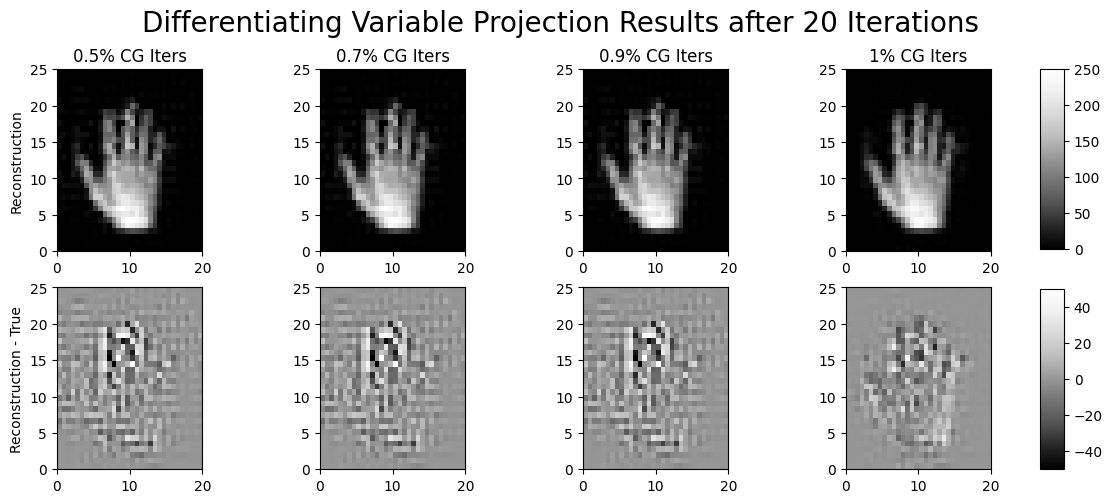

In [39]:
fig, ax = plt.subplots(2, len(proportions), figsize=(12,4))

for i in range(len(proportions)):
    #ax[0,i].axis('off')
    #ax[1,i].axis('off')

    plt.sca(ax[0,i])
    im_0 = view_image_2d(f0_grads[i],domain_R, kwargs={'clim':(0,250), 'cmap':'Greys_r'})
    plt.title("{}% CG Iters".format(proportions[i]))

    plt.sca(ax[1,i])
    im_1 = view_image_2d(f0_grads[i] - R,domain_R, kwargs={'clim':(-50,50), 'cmap':'Greys_r'})

ax[0,0].set_ylabel("Reconstruction")
ax[1,0].set_ylabel("Reconstruction - True")

fig.subplots_adjust(0,0,.84,1)

# Create colorbar axes
cbar_ax1 = fig.add_axes([0.85, 0.55, 0.02, 0.45])  # x, y, width, height
cbar_ax2 = fig.add_axes([0.85, 0.0, 0.02, 0.45])

# Create colorbars in the new axes
cbar1 = plt.colorbar(im_0, cax=cbar_ax1)
cbar2 = plt.colorbar(im_1, cax=cbar_ax2)

plt.suptitle('Differentiating Variable Projection Results after 20 Iterations', y = 1.15, x=.45, size=20)


plt.show()


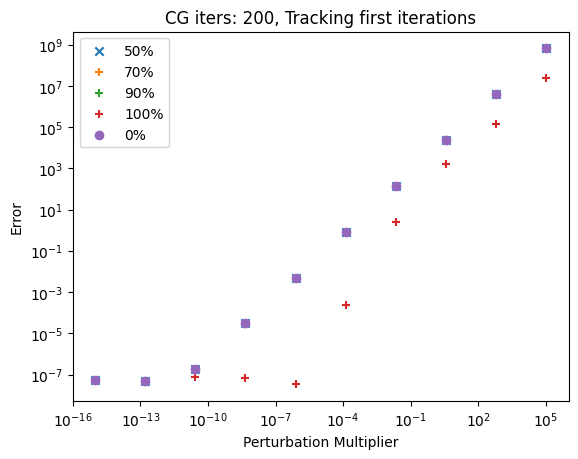

In [25]:
maxcg_iters = 200 # verified that all iterations reach max_iters before stopping
proportions = [0.5,  0.7,  0.9, 1]


H = torch.logspace(5,-15,10)
# Loop through each subplot and plot

fifty = []
seventy = []
ninety = []
all_grad = []
no_grad = []
v = Jac_fn_firstdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 1).T @ res_fn_nodiff(numpy_to_tensor(results.x).flatten(), maxcg_iters) 
v /= torch.norm(v)
f_x = res_fn_nodiff(numpy_to_tensor(results.x).flatten(), maxcg_iters)
Jacv_fifty = Jac_fn_firstdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0.5) @ v
Jacv_seventy = Jac_fn_firstdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0.7) @ v
Jacv_ninety = Jac_fn_firstdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0.9) @ v
Jacv_all = Jac_fn_firstdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 1) @ v
Jacv_no = Jac_fn_firstdiff(numpy_to_tensor(results.x).flatten(), maxcg_iters, 0) @ v

for h in H:
    fifty.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_fifty).detach())
    seventy.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_seventy).detach())
    ninety.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_ninety).detach())
    all_grad.append(torch.norm(res_fn(numpy_to_tensor(results.x).flatten() + h * v, maxcg_iters) - f_x - h * Jacv_all).detach())
    no_grad.append(torch.norm(res_fn(numpy_to_tensor(results.x) + h * v, maxcg_iters) - f_x - h * Jacv_no).detach())
plt.scatter(H, fifty, marker='x', label = '50%')
plt.scatter(H, seventy, marker='+', label = '70%')
plt.scatter(H, ninety, marker='+', label = '90%')
plt.scatter(H, all_grad, marker='+', label = '100%')
plt.scatter(H, no_grad, marker='o', label = '0%')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Perturbation Multiplier")
plt.ylabel("Error")
plt.title(f"CG iters: 200, Tracking first iterations")

plt.show()